# Long Term Influenza Outbreak Forecast using Time-Precidence Correlation of Web data

## 1. 초기 세팅

### 1-1. 라이브러리 세팅

In [1]:
# 라이브러리 autoreload

%load_ext autoreload
%autoreload 2

In [2]:
# 필요 라이브러리 import

import tensorflow as tf
import tensorflow_addons as tfa 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from utils.preprocessing import normalize
from model.proposed import Proposed

2021-12-26 16:00:12.247791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### 1-2. 데이터 세팅

In [3]:
# US, AU, KR influenza data load

flu = {
    'us': pd.read_csv('./data/US_flu.csv'), 
    'au': pd.read_csv('./data/AU_flu.csv'),
    'kr': pd.read_csv('./data/KR_flu.csv') 
}

In [4]:
# US, AU, KR Google trends data load

trends = {
    'us': pd.read_csv('./data/US_trends.csv'), 
    'au': pd.read_csv('./data/AU_trends.csv'), 
    'kr': pd.read_csv('./data/KR_trends.csv') 
}

## 2. EDA

### 2-1. 데이터 살펴보기

In [5]:
flu['us']

,weeks,ILI
0,10-01,19.8284
1,10-02,18.2749
2,10-03,19.2606
3,10-04,19.2495
4,10-05,20.8877
...,...,...
535,20-16,25.7453
536,20-17,20.2111
537,20-18,16.2086
538,20-19,13.5240


In [6]:
# flu 데이터의 형태 출력

for nation in flu:
    print(f'{nation} flu data shape: {flu[nation].shape}')

us flu data shape: (540, 2)
au flu data shape: (540, 2)
kr flu data shape: (540, 2)


In [7]:
trends['us']

,weeks,influenza,H1N1 flu,swine flu,Flu,H1N1,seasonal flu,H1N1 virus,flu virus,H1N1 swine flu,...,polio epidemic,Afluria seasonal flu,hemolytic uremic syndrome HUS,croup,Jeff Duchin,inactivated vaccine,fevers aches,invasive pneumococcal disease,Sudden Acute Respiratory Syndrome,commonly infect humans
0,17-35,0,0,0,6,0,0,0,1,0,...,1,0,0,40,0,46,0,0,0,0
1,17-36,1,0,0,8,0,0,0,2,0,...,0,0,0,50,0,50,14,14,0,0
2,17-37,1,0,0,9,0,0,0,2,0,...,0,0,0,51,0,46,14,14,0,0
3,17-38,1,0,0,11,0,0,0,2,0,...,0,0,0,58,0,87,0,0,0,0
4,17-39,1,0,0,12,0,0,0,2,0,...,0,0,0,68,0,54,14,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,20-16,2,0,1,24,2,3,1,10,1,...,5,0,0,8,1,76,0,0,0,0
138,20-17,2,0,1,19,1,2,1,10,1,...,8,0,0,10,0,41,0,0,0,0
139,20-18,2,0,1,18,1,2,1,8,1,...,6,0,0,5,0,56,0,11,0,0
140,20-19,2,0,1,16,1,2,1,6,1,...,7,0,0,7,0,28,0,0,0,0


In [8]:
# trends 데이터의 형태 출력

for nation in trends:
    print(f'{nation} trends data shape: {trends[nation].shape}')

us trends data shape: (142, 1001)
au trends data shape: (142, 966)
kr trends data shape: (142, 1001)


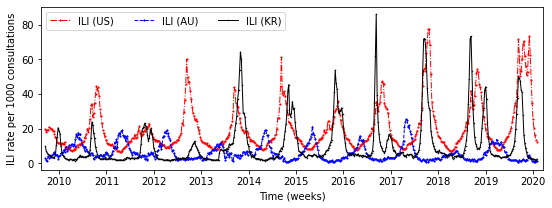

In [9]:
# flu 데이터 시각화

ploting_config = {
    'us': {
        'c': 'red',
        'ls': '-.',
        'marker': 's',
    },
    'au': {
        'c': 'blue',
        'ls': '--',
        'marker': 'D',
    },
    'kr': {
        'c': 'black',
        'ls': '-',
        'marker': '.',
    }
}

plt.figure(figsize=(9, 3))
for nation, flu_df in flu.items():
    plt.plot(flu_df['ILI'],
             label=f'ILI ({nation.upper()})',
             c=ploting_config[nation]['c'],
             ls=ploting_config[nation]['ls'],
             marker=ploting_config[nation]['marker'],
             markersize=1, linewidth=1)

plt.xticks(range(15, 541, 52), [str(i) for i in range(2010, 2021)])
plt.xlabel('Time (weeks)')
plt.ylabel('ILI rate per 1000 consultations')
plt.xlim(0-5, 541+5)
plt.legend(ncol=3)
plt.show()

### 2-2. 웹 데이터의 시간 차 계산

In [10]:
MIN_PRECIDENCE = 3 # 최소 시간 선행
MAX_PRECIDENCE = 15 # 최대 시간 선행
precidences = [i for i in range(MIN_PRECIDENCE, MAX_PRECIDENCE+1)]

corrs = {}

for nation in ['us', 'au', 'kr']:
    print('='*10, nation, '='*10)
    flu_data = flu[nation]
    trends_data = trends[nation]
    # trends_data = trends_data[trends_data.weeks>='18-05'].reset_index(drop=True)

    corrs_by_prcds = []
    keywords = trends_data.columns[1:] # weeks를 제외한 모든 열
    for keyword in tqdm(keywords):
        # correlation을 계산할 데이터 선택
        # trends의 weeks와 일치하는 flu데이터
        base = flu_data[flu_data.weeks.isin(trends_data.weeks)].ILI.reset_index(drop=True)
        target = trends_data[keyword] # 각 키워드의 trends 데이터
        
        corr_list = []
        for prcd in precidences:
            corr = base.corr(target.shift(prcd)) # precidence에 따라 trends를 shift/corr 계산
            corr_list.append(corr)
        corrs_by_prcds.append(corr_list)

    corrs_by_prcds = pd.DataFrame(corrs_by_prcds).T # 데이터 프레임 형식
    corrs_by_prcds.columns = keywords 
    corrs_by_prcds.insert(0, 'prcd', precidences) # 첫 번째 열에 precidence를 표시
    corrs[nation] = corrs_by_prcds

  2%|▏         | 18/1000 [00:00<00:05, 178.29it/s]

========== us ==========


  2%|▏         | 18/965 [00:00<00:05, 171.02it/s]

========== au ==========


  2%|▏         | 23/1000 [00:00<00:04, 229.34it/s]

========== kr ==========


100%|██████████| 1000/1000 [00:04<00:00, 221.51it/s]


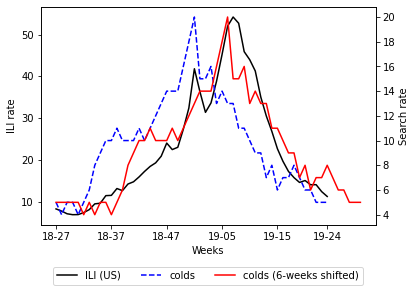

In [11]:
# US의 "colds" 키워드에 대한 시간 차 웹 데이터 검색 비율 예시 시각화

nation = 'us'
keyword = 'colds'
prcd = corrs[nation][keyword].argmax() + MIN_PRECIDENCE # 시간 선행

flu_df = flu[nation]
trends_df = trends[nation]
base_weeks = flu_df[(flu_df.weeks>='18-27') & (flu_df.weeks<='19-24')].weeks
shifted_weeks = flu_df[base_weeks.index[0]-prcd:base_weeks.index[-1]+1].weeks

fig, ax1 = plt.subplots()
ax1.plot(flu_df[flu_df.weeks.isin(base_weeks)].ILI.values,
         c='k', ls='-', label=f'ILI ({nation.upper()})')
ax2 = ax1.twinx()
ax2.plot(trends_df[trends_df.weeks.isin(base_weeks)][keyword].values,
         c='b', ls='--', label=keyword)
ax2.plot(trends_df[trends_df.weeks.isin(shifted_weeks)][keyword].values,
         c='r', ls='-', label=f'{keyword} ({prcd}-weeks shifted)')

ax1.set_xticks([0, 10, 20, 30, 40, 49])
ax1.set_xticklabels(base_weeks.values[[0, 10, 20, 30, 40, 49]])

ax1.set_ylabel('ILI rate')
ax2.set_ylabel('Search rate')
ax1.set_xlabel('Weeks')

fig.legend(loc='lower center', bbox_to_anchor=(0.5,-0.3), bbox_transform=ax1.transAxes, ncol=3)
plt.show()

## 3. 예측 모델

### 3-1. 데이터 전처리

In [12]:
# 데이터 슬라이스

def slice_data(flu_data, trends_data, corrs_data, 
               lookback=5, lookahead=5, topn=1, historic=7):
    flu_inputs = []
    flu_labels = []
    web_past_inputs = []
    web_future_inputs = []
    
    # 상관 계수가 높은 것 순서대로 정렬
    keywords_rank = corrs_data.max().sort_values(ascending=False)
    # topn 개의 keywords만 사용할 예정 (index 1의 경우 prcd 열이므로 제외)
    keywords_rank = [(keyword, coef, corrs_data[keyword].argmax()+MIN_PRECIDENCE)
                     for keyword, coef in keywords_rank[1:topn+1].items()]
    
    # label의 시간을 기준으로 가용 가능한 데이터 범위 선택
    # |                       Total weeks                           |
    # |  MAX_PRECIDENCE  |   lookback   | < avaliable label weeks > |
    available_weeks = trends_data['weeks'][MAX_PRECIDENCE+lookback:-lookahead+1].values
    for year_week in available_weeks:
        year, week = map(int, year_week.split('-'))
        
        flu_pos = flu_data[flu_data.weeks==f'{year}-{week:02}'].index[0]
        
        # 현재 label 위치를 기준으로 [lookback 스텝 이전, 현재 label 위치-1]까지
        curr_flu = flu_data[flu_pos-lookback:flu_pos].ILI.values.reshape(-1, 1)
        # 현재 label 위치를 기준으로 [현재 label 위치, lookahead 스텝 이후]까지
        curr_lbl = flu_data[flu_pos:flu_pos+lookahead].ILI.values.reshape(-1, 1)
        
        # 과거 년도 데이터 탐색
        for h in range(1, historic+1):
            # 같은 구간에서 년도만 다르게 하여 값을 선택
            # 예) 현재 18-03 week 라면 17-03, 16-03, ... 에 대한 값들을 선택 
            flu_pos = flu_data[flu_data.weeks==f'{year-h}-{week:02}'].index[0]
            historic_flu = flu_data[flu_pos-lookback:flu_pos].ILI.values.reshape(-1, 1)
            curr_flu = np.hstack([curr_flu, historic_flu])
        
        # 웹 데이터 탐색
        web_past = []
        web_future = []
        for keyword, coef, prcd in keywords_rank:
            # flu 데이터와 동일한 구조이지만 precidence만큼 이전 데이터 사용
            web_pos = trends_data[trends_data.weeks==f'{year}-{week:02}'].index[0]
            curr_web_past = trends_data[keyword][web_pos-lookback-prcd:web_pos-prcd].values.reshape(-1, 1)
            curr_web_future = np.random.uniform(1e-6, 1e-4, (lookahead, 1))
            curr_web_future[:prcd] = trends_data[keyword][web_pos-prcd:web_pos-prcd+lookahead].values.reshape(-1, 1)[:prcd]
            
            web_past.append(curr_web_past)
            web_future.append(curr_web_future)
            
        web_past = np.hstack(web_past)
        web_future = np.hstack(web_future)
        
        flu_inputs.append(curr_flu)
        flu_labels.append(curr_lbl)
        web_past_inputs.append(web_past)
        web_future_inputs.append(web_future)
    
    return flu_inputs, flu_labels, web_past_inputs, web_future_inputs

In [13]:
# 데이터 정규화 (MinMax)

flu_norm = {nation: normalize(flu_df) for nation, flu_df in flu.items()}
trends_norm = {nation: normalize(trends_df) for nation, trends_df in trends.items()}

### 3-2. 모델 학습

In [14]:
# hyper parameters

LOOKBACK = 8
LOOKAHEAD = 10
LAYER_SIZE = 128
TOPN = {'us': 1, 'au': 1, 'kr': 9}

EPOCHS = 200
BATCH_SIZE = 64


In [16]:
datasets = {nation: {} for nation in ['us', 'au', 'kr']}
models = {}
histories = {}

for nation in ['us', 'au', 'kr']:
    print('='*10, nation, '='*10)
    flu_inputs, flu_labels, web_past_inputs, web_future_inputs = slice_data(flu_norm[nation][0], 
                                                                            trends_norm[nation][0], 
                                                                            corrs[nation], 
                                                                            lookback=LOOKBACK,
                                                                            lookahead=LOOKAHEAD,
                                                                            topn=TOPN[nation])
    
    train_flu_inputs, test_flu_inputs = train_test_split(flu_inputs,
                                                     test_size=0.2,
                                                     shuffle=False)

    train_flu_labels, test_flu_labels = train_test_split(flu_labels,
                                                        test_size=0.2,
                                                        shuffle=False)

    train_web_past_inputs, test_web_past_inputs = train_test_split(web_past_inputs,
                                                                test_size=0.2,
                                                                shuffle=False)

    train_web_future_inputs, test_web_future_inputs = train_test_split(web_future_inputs,
                                                                    test_size=0.2,
                                                                    shuffle=False)
    
    datasets[nation]['train'] = tf.data.Dataset.from_tensor_slices(((train_flu_inputs, 
                                                                     train_web_past_inputs, 
                                                                     train_web_future_inputs), 
                                                                    train_flu_labels))
    datasets[nation]['test'] = tf.data.Dataset.from_tensor_slices(((test_flu_inputs, 
                                                                    test_web_past_inputs, 
                                                                    test_web_future_inputs),
                                                                   test_flu_labels))
    
    tf.keras.backend.clear_session()
    proposed_model = Proposed()
    proposed_model.compile(loss='mse', optimizer='adam')
    
    histories[nation] = proposed_model.fit(datasets[nation]['train'].batch(BATCH_SIZE),
                                           epochs=EPOCHS, verbose=0,
                                           callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)])
    models[nation] = proposed_model
    

========== us ==========


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

========== au ==========


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

========== kr ==========


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

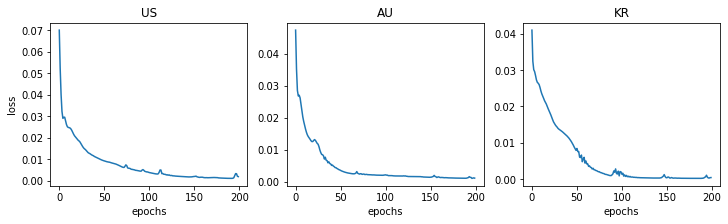

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i, nation in enumerate(['us', 'au', 'kr']):
    ax[i].plot(histories[nation].history['loss'])
    ax[i].set_title(nation.upper())
    ax[i].set_xlabel('epochs')
ax[0].set_ylabel('loss')
plt.show()

### 3-3. 예측 결과

In [19]:
labels = {nation: {} for nation in ['us', 'au', 'kr']}
predictions = {nation: {} for nation in ['us', 'au', 'kr']}

for nation in ['us', 'au', 'kr']:
    train_inputs, train_labels = next(iter(datasets[nation]['train'].batch(1000)))
    train_preds = models[nation](train_inputs)

    test_inputs, test_labels = next(iter(datasets[nation]['test'].batch(1000)))
    test_preds = models[nation](test_inputs)
    
    labels[nation]['train'] = train_labels
    labels[nation]['test'] = test_labels
    
    predictions[nation]['train'] = train_preds
    predictions[nation]['test'] = test_preds    

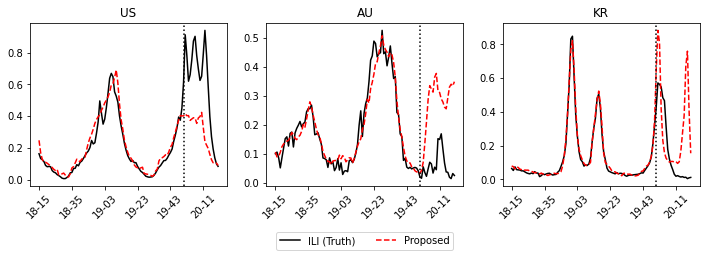

In [20]:
ahead = 10 # 확인할 예측 스텝, [1, 10]의 범위의 값이며 예측 주차를 의미함.

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for i, nation in enumerate(['us', 'au', 'kr']):
    available_weeks = trends[nation]['weeks'][MAX_PRECIDENCE+LOOKBACK+ahead-1:len(trends[nation]['weeks'])-LOOKAHEAD+ahead].values
    train_labels, test_labels = labels[nation]['train'], labels[nation]['test']
    train_preds, test_preds = predictions[nation]['train'], predictions[nation]['test']
    
    ax[i].plot(tf.concat([train_labels[:, ahead-1], test_labels[:, ahead-1]], axis=0),
               label='ILI (Truth)', c='k')
    ax[i].plot(tf.concat([train_preds[:, ahead-1], test_preds[:, ahead-1]], axis=0),
               label='Proposed', c='r', ls='--')
    ax[i].axvline(x=len(train_labels), c='k', ls=':')
    
    ax[i].set_title(nation.upper())
    ax[i].set_xticks(range(0, len(available_weeks)+1, 20))
    ax[i].set_xticklabels([available_weeks[i] for i in range(0, len(available_weeks)+1, 20)],
                          rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.25), ncol=2, 
               labels=['ILI (Truth)', 'Proposed'])
plt.show()